In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay

import xgboost as xgb
import shap
import joblib

sns.set(style="whitegrid")


In [2]:
# Load churn dataset
df = pd.read_csv("churn.csv")
print(df.shape)
df.head()


(1000, 9)


,customerID,tenure,MonthlyCharges,TotalCharges,gender,Contract,PaymentMethod,InternetService,Churn
0,CUST00001,51,106.70,5466.04,Female,Two year,Credit card,DSL,No
1,CUST00002,14,60.80,862.39,Female,One year,Bank transfer,No,No
2,CUST00003,71,75.17,5297.66,Male,One year,Mailed check,Fiber optic,No
3,CUST00004,60,45.39,2688.56,Male,One year,Credit card,No,No
4,CUST00005,20,39.61,751.58,Female,Month-to-month,Bank transfer,DSL,No


In [4]:

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Convert target column
df['Churn_flag'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Encode categorical features
cat_cols = [c for c in df.select_dtypes(include="object").columns if c not in ['customerID','Churn']]
for c in cat_cols:
    df[c] = LabelEncoder().fit_transform(df[c].astype(str))

# Features & target
features = ['tenure','MonthlyCharges','TotalCharges'] + cat_cols
X = df[features]
y = df['Churn_flag']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (800, 3) Test shape: (200, 3)


In [5]:
# Prepare data
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Handle imbalance
scale_pos_weight = (y_train==0).sum() / (y_train==1).sum()

# XGBoost parameters
params = {
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'eta':0.05,
    'max_depth':6,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'scale_pos_weight': scale_pos_weight,
    'seed':42
}

# Train with early stopping
bst = xgb.train(params, dtrain, num_boost_round=500,
                evals=[(dtrain,'train'), (dtest,'valid')],
                early_stopping_rounds=30, verbose_eval=50)

# Predictions
y_prob = bst.predict(dtest)
y_pred = (y_prob > 0.5).astype(int)


[0]	train-auc:0.94852	valid-auc:0.88976
[36]	train-auc:0.98938	valid-auc:0.93280


ROC AUC: 0.932261891921044

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.79      0.87       127
           1       0.72      0.95      0.82        73

    accuracy                           0.84       200
   macro avg       0.84      0.87      0.84       200
weighted avg       0.87      0.84      0.85       200



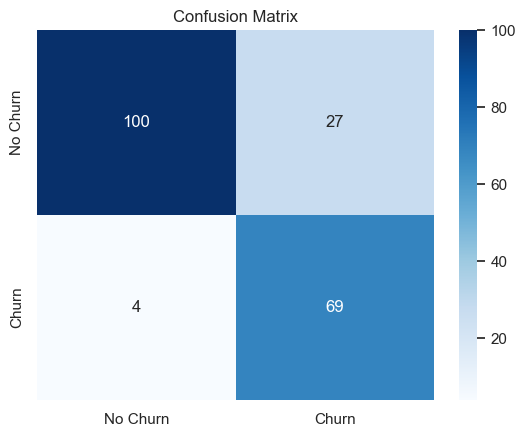

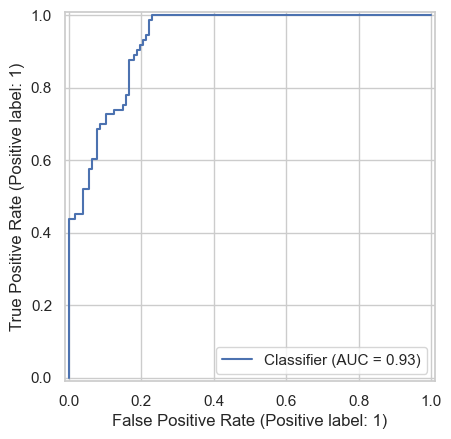

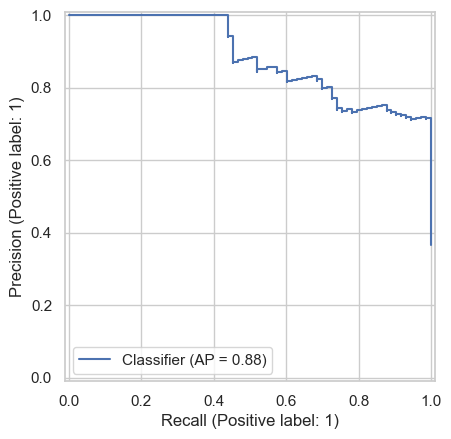

In [6]:
# Metrics
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Churn", "Churn"],
            yticklabels=["No Churn", "Churn"])
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.show()

# Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(y_test, y_prob)
plt.show()


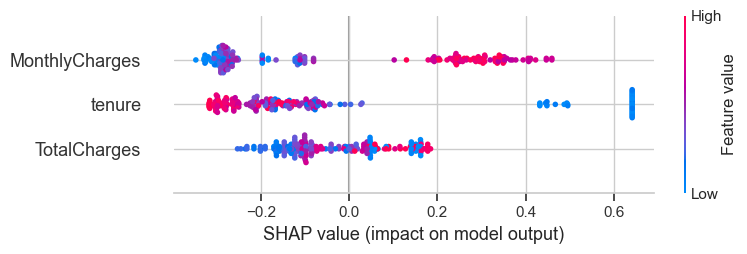

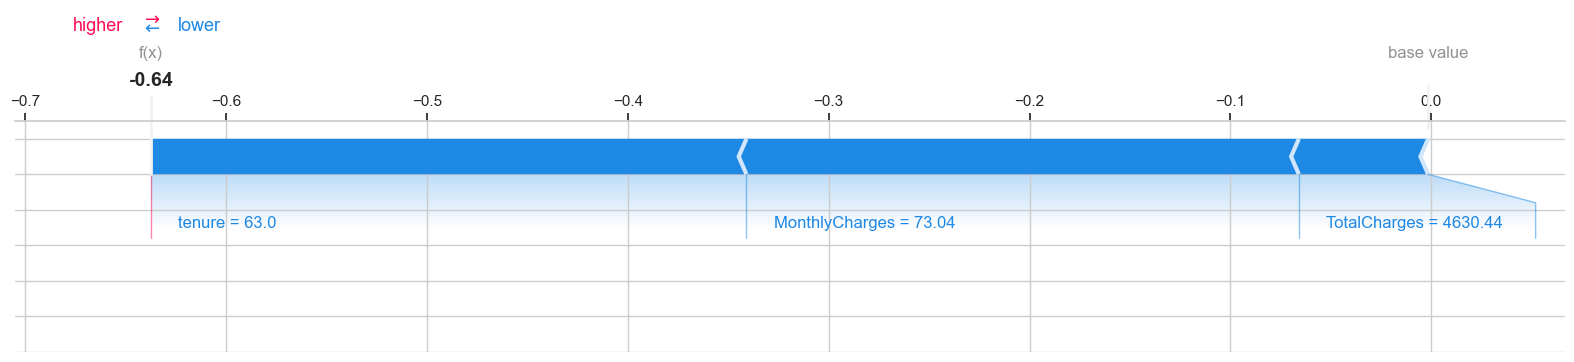

In [7]:
# Global & local feature importance
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test)

# Global summary
shap.summary_plot(shap_values, X_test)

# Local explanation (example customer)
idx = 0
shap.force_plot(explainer.expected_value,
                shap_values[idx,:],
                X_test.iloc[idx,:],
                matplotlib=True, show=True)


In [8]:
# Save model
joblib.dump(bst, "xgb_churn_model.joblib")

# Save predictions
out = X_test.copy()
out['customerID'] = df.loc[X_test.index, 'customerID']
out['probability'] = y_prob
out['prediction'] = y_pred
out.to_csv("churn_predictions.csv", index=False)

print(" Model and predictions saved")


 Model and predictions saved
